<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Penalized Regression

### Author: Gloria Rivas Nóvoa
<br>

**Analyzing and Plotting Bias in Penalized Regression**

___
**How does varying the regularization parameter $\lambda$ in Ridge and Lasso regression impact the trade-off between bias and variance?**

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 100
n_features = 50

X = np.random.randn(n_samples, n_features)

true_beta = np.zeros(n_features)
non_zero_indices = np.random.choice(n_features, size=5, replace=False)
true_beta[non_zero_indices] = np.random.uniform(-2, 2, size=5)

sigma_squared = 2.0
sigma = np.sqrt(sigma_squared)

epsilon = np.random.normal(0, sigma, n_samples)

y = X @ true_beta + epsilon

df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(n_features)])
df['y'] = y

print(df.head())

print("\nTrue Coefficients (mostly zeros, a few non-zero):")
print(true_beta)
print(f"\nNoise standard deviation (σ): {sigma:.2f}, Variance (σ²): {sigma_squared:.2f}")


         X1        X2        X3        X4        X5        X6        X7  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1  0.324084 -0.385082 -0.676922  0.611676  1.031000  0.931280 -0.839218   
2 -1.415371 -0.420645 -0.342715 -0.802277 -0.161286  0.404051  1.886186   
3  0.250493  0.346448 -0.680025  0.232254  0.293072 -0.714351  1.865775   
4  0.357787  0.560785  1.083051  1.053802 -1.377669 -0.937825  0.515035   

         X8        X9       X10  ...       X42       X43       X44       X45  \
0  0.767435 -0.469474  0.542560  ...  0.171368 -0.115648 -0.301104 -1.478522   
1 -0.309212  0.331263  0.975545  ...  0.968645 -0.702053 -0.327662 -0.392108   
2  0.174578  0.257550 -0.074446  ...  1.307143 -1.607483  0.184634  0.259883   
3  0.473833 -1.191303  0.656554  ...  0.856399  0.214094 -1.245739  0.173181   
4  0.513786  0.515048  3.852731  ... -0.114736  0.504987  0.865755 -1.200296   

        X46       X47       X48       X49       X50         y  
0 -0

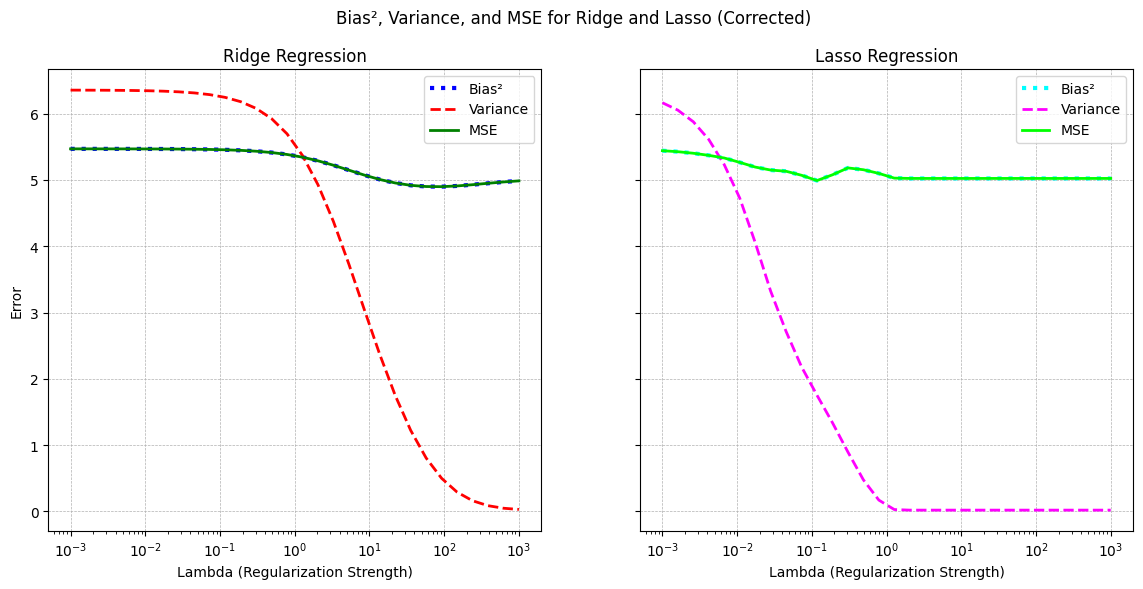


Ridge Bias-Variance-MSE Check:
     Lambda  Ridge Bias²  Ridge Variance  Ridge MSE  Bias² + Variance (Ridge)
0  0.001000     1.896828        6.357684   5.471309                  8.254512
1  0.001610     1.896743        6.357097   5.471233                  8.253839
2  0.002593     1.896605        6.356152   5.471110                  8.252757
3  0.004175     1.896383        6.354631   5.470912                  8.251014
4  0.006723     1.896027        6.352183   5.470594                  8.248210

Lasso Bias-Variance-MSE Check:
     Lambda  Lasso Bias²  Lasso Variance  Lasso MSE  Bias² + Variance (Lasso)
0  0.001000     1.868629        6.167431   5.443604                  8.036060
1  0.001610     1.851261        6.055455   5.428307                  7.906716
2  0.002593     1.824616        5.880063   5.405141                  7.704679
3  0.004175     1.782714        5.612465   5.373335                  7.395179
4  0.006723     1.717576        5.233332   5.333398                  6.950908


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Set random seed
np.random.seed(42)

# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 30)  # From 0.001 to 1000

# Prepare lists for Bias², Variance, and MSE
ridge_bias2, ridge_variance, ridge_mse = [], [], []
lasso_bias2, lasso_variance, lasso_mse = [], [], []

# K-Fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha in lambda_values:
    ridge_fold_preds, lasso_fold_preds = [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train Ridge and Lasso models
        ridge_model = Ridge(alpha=alpha).fit(X_train, y_train)
        lasso_model = Lasso(alpha=alpha, max_iter=10000).fit(X_train, y_train)

        # Save predictions
        ridge_fold_preds.append(ridge_model.predict(X_test))
        lasso_fold_preds.append(lasso_model.predict(X_test))

    # Convert predictions to arrays
    ridge_preds = np.array(ridge_fold_preds)  # shape (folds, test_samples)
    lasso_preds = np.array(lasso_fold_preds)

    # Mean prediction over folds (expected value)
    ridge_mean_preds = np.mean(ridge_preds, axis=0)
    lasso_mean_preds = np.mean(lasso_preds, axis=0)

    # True y (from last test set)
    y_test = y[test_index]

    # Bias²: squared difference between expected prediction and true value
    ridge_bias2.append(np.mean((ridge_mean_preds - y_test) ** 2))
    lasso_bias2.append(np.mean((lasso_mean_preds - y_test) ** 2))

    # Variance: variability in predictions across folds
    ridge_variance.append(np.mean(np.var(ridge_preds, axis=0, ddof=1)))
    lasso_variance.append(np.mean(np.var(lasso_preds, axis=0, ddof=1)))

    # MSE: total prediction error on the mean prediction
    ridge_mse.append(mean_squared_error(y_test, ridge_mean_preds))
    lasso_mse.append(mean_squared_error(y_test, lasso_mean_preds))


# Plot Bias², Variance, and MSE for Ridge and Lasso with corrected values
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Ridge Regression Plot
axes[0].plot(lambda_values, ridge_bias2, label="Bias²", linestyle="dotted", color="blue", linewidth=3)
axes[0].plot(lambda_values, ridge_variance, label="Variance", linestyle="dashed", color="red", linewidth=2)
axes[0].plot(lambda_values, ridge_mse, label="MSE", linestyle="-", color="green", linewidth=2)
axes[0].set_xscale("log")
axes[0].set_xlabel("Lambda (Regularization Strength)")
axes[0].set_ylabel("Error")
axes[0].set_title("Ridge Regression")
axes[0].legend()
axes[0].grid(True, linestyle="--", linewidth=0.5)

# Lasso Regression Plot
axes[1].plot(lambda_values, lasso_bias2, label="Bias²", linestyle="dotted", color="cyan", linewidth=3)
axes[1].plot(lambda_values, lasso_variance, label="Variance", linestyle="dashed", color="magenta", linewidth=2)
axes[1].plot(lambda_values, lasso_mse, label="MSE", linestyle="-", color="lime", linewidth=2)
axes[1].set_xscale("log")
axes[1].set_xlabel("Lambda (Regularization Strength)")
axes[1].set_title("Lasso Regression")
axes[1].legend()
axes[1].grid(True, linestyle="--", linewidth=0.5)

plt.suptitle("Bias², Variance, and MSE for Ridge and Lasso (Corrected)")
plt.show()

# Print results for verification
print("\nRidge Bias-Variance-MSE Check:")
print(ridge_data.head())

print("\nLasso Bias-Variance-MSE Check:")
print(lasso_data.head())


**- MSE decomposition into bias and variance.**
The Mean Squared Error (MSE) is a fundamental metric in regression analysis. It can be decomposed into Bias², Variance, and Irreducible Error.